In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

from scipy import stats
import collections

import warnings
# warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from pathlib import Path

import db_queries as db
import vivarium_helpers.id_helper as idh
import gbd_mapping
from vivarium import Artifact

# Add the repo directory vivarium_research_ciff_sam/ to sys.path
import os, sys
repo_path = os.path.abspath('../..')
sys.path.append(repo_path)
print("pwd:")
!pwd
print(f"{repo_path=}")

# Assumes vivarium_research_ciff_sam/ is in sys.path
# import model_validation.vivarium_transformed_output as vto
# import model_validation.vivarium_raw_output as vro
import model_validation.vivarium_output_processing as vp
import model_validation.ciff_sam_results as csr
import model_validation.ciff_sam_plots as csp

%load_ext autoreload
%autoreload 2

!whoami
!date

pwd:
/ihme/homes/ndbs/vivarium_research_ciff_sam/model_validation/model4
repo_path='/ihme/homes/ndbs/vivarium_research_ciff_sam'
ndbs
Sat Oct 30 11:19:02 PDT 2021


# Load data

In [2]:
results = csr.VivariumResults.cleaned_from_model_spec(4.1)
results.table_names()

['wasting_transition_count',
 'wasting_state_person_time',
 'deaths',
 'stunting_state_person_time',
 'population',
 'ylls',
 'ylds',
 'person_time',
 'cause_state_person_time',
 'cause_transition_count']

In [3]:
results.wasting_state_person_time

,sex,year,wasting_state,measure,input_draw,scenario,value,sq_lns,wasting_treatment,age
0,female,2022,mild_child_wasting,state_person_time,29,baseline,0.000000,covered,covered,early_neonatal
1,female,2022,mild_child_wasting,state_person_time,29,baseline,0.000000,covered,uncovered,early_neonatal
2,female,2022,mild_child_wasting,state_person_time,29,baseline,201.939767,uncovered,covered,early_neonatal
3,female,2022,mild_child_wasting,state_person_time,29,baseline,207.442847,uncovered,uncovered,early_neonatal
...,...,...,...,...,...,...,...,...,...,...
34556,male,2026,susceptible_to_child_wasting,state_person_time,946,wasting_treatment,0.000000,covered,covered,2_to_4
34557,male,2026,susceptible_to_child_wasting,state_person_time,946,wasting_treatment,0.000000,covered,uncovered,2_to_4
34558,male,2026,susceptible_to_child_wasting,state_person_time,946,wasting_treatment,198117.045859,uncovered,covered,2_to_4
34559,male,2026,susceptible_to_child_wasting,state_person_time,946,wasting_treatment,21226.153320,uncovered,uncovered,2_to_4


# Create a dictionary to store figures

In [21]:
figs = {}

# Compute percent treated according to `wasting_treatment` column

In [4]:
percent_treated_by_age_year = csr.get_prevalence(
    results,
    'wasting_treatment',
    strata=['age', 'year'],
    multiplier=100
)
percent_treated_by_age_year

,age,year,input_draw,scenario,wasting_treatment,value,numerator_measure,denominator_measure,multiplier,measure
0,1-5_months,2022,29,baseline,covered,49.502033,state_person_time,state_person_time,100,prevalence
1,1-5_months,2022,29,baseline,uncovered,50.497967,state_person_time,state_person_time,100,prevalence
2,1-5_months,2022,29,sqlns,covered,49.502033,state_person_time,state_person_time,100,prevalence
3,1-5_months,2022,29,sqlns,uncovered,50.497967,state_person_time,state_person_time,100,prevalence
...,...,...,...,...,...,...,...,...,...,...
2156,late_neonatal,2026,946,sqlns,covered,89.991849,state_person_time,state_person_time,100,prevalence
2157,late_neonatal,2026,946,sqlns,uncovered,10.008151,state_person_time,state_person_time,100,prevalence
2158,late_neonatal,2026,946,wasting_treatment,covered,89.991849,state_person_time,state_person_time,100,prevalence
2159,late_neonatal,2026,946,wasting_treatment,uncovered,10.008151,state_person_time,state_person_time,100,prevalence


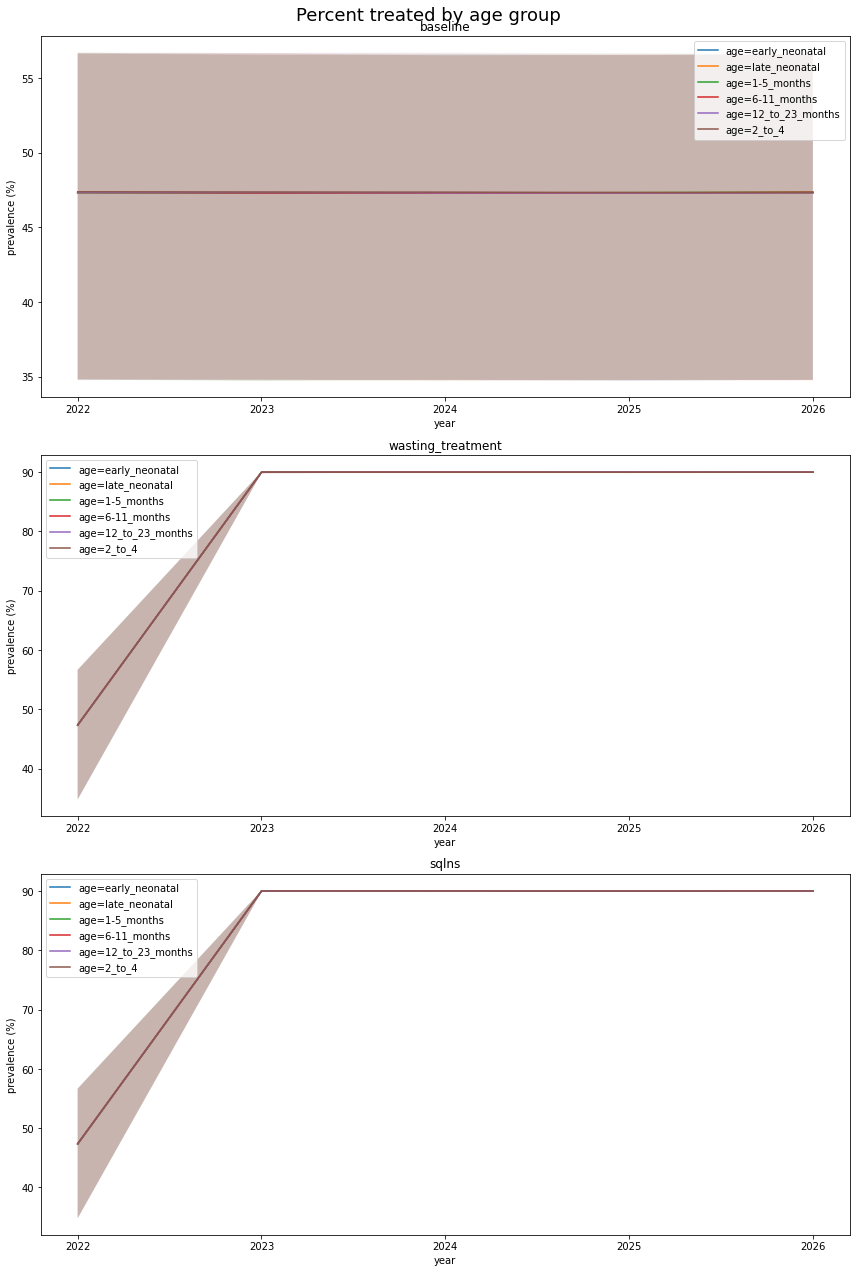

In [5]:
fig = csp.plot_over_time_by_column_for_each_scenario(
    percent_treated_by_age_year.query("wasting_treatment=='covered'"),
    colname='age',
    ylabel='prevalence (%)',
    suptitle='Percent treated by age group',
    uncertainty=True
)

# Check the value of baseline coverage

It should be 48.8% (95% CI: 37.4-60.4) -- are we using a normal distribution?

We are getting 47.3% (95% UI: 34.8-56.6) for the 12 draws we picked -- that seems reasonable.

In [6]:
(37.4+60.4)/2

48.9

In [7]:
vp.describe(
    percent_treated_by_age_year.query(
        "wasting_treatment=='covered' and scenario=='baseline' and year=='2022'")
)

,,,,,,,,count,mean,std,min,2.5%,50%,97.5%,max
age,denominator_measure,measure,multiplier,numerator_measure,scenario,wasting_treatment,year,,,,,,,,
1-5_months,state_person_time,prevalence,100,state_person_time,baseline,covered,2022,12.0,47.316556,6.606332,33.007542,34.791336,48.031804,56.695910,58.006529
12_to_23_months,state_person_time,prevalence,100,state_person_time,baseline,covered,2022,12.0,47.322266,6.596915,32.928505,34.761904,47.855264,56.651243,57.928392
2_to_4,state_person_time,prevalence,100,state_person_time,baseline,covered,2022,12.0,47.380759,6.611588,33.009900,34.808575,47.934573,56.698991,58.010613
6-11_months,state_person_time,prevalence,100,state_person_time,baseline,covered,2022,12.0,47.346730,6.582457,33.054295,34.827235,47.999224,56.636371,57.881335
early_neonatal,state_person_time,prevalence,100,state_person_time,baseline,covered,2022,12.0,47.314654,6.590164,33.058424,34.833187,48.013176,56.629312,57.938547
late_neonatal,state_person_time,prevalence,100,state_person_time,baseline,covered,2022,12.0,47.303010,6.597603,33.052556,34.821614,48.003712,56.643250,57.955239


In [8]:
vp.describe(
    percent_treated_by_age_year.query(
        "wasting_treatment=='covered' and scenario=='baseline' and year=='2024'")
)

,,,,,,,,count,mean,std,min,2.5%,50%,97.5%,max
age,denominator_measure,measure,multiplier,numerator_measure,scenario,wasting_treatment,year,,,,,,,,
1-5_months,state_person_time,prevalence,100,state_person_time,baseline,covered,2024,12.0,47.295021,6.588391,32.929432,34.744238,47.862745,56.536725,57.851824
12_to_23_months,state_person_time,prevalence,100,state_person_time,baseline,covered,2024,12.0,47.308353,6.604034,33.017643,34.786001,47.881363,56.617093,57.918783
2_to_4,state_person_time,prevalence,100,state_person_time,baseline,covered,2024,12.0,47.357994,6.610015,32.965861,34.777698,47.954989,56.694274,57.989693
6-11_months,state_person_time,prevalence,100,state_person_time,baseline,covered,2024,12.0,47.294527,6.569269,32.934272,34.734587,47.845968,56.501766,57.786717
early_neonatal,state_person_time,prevalence,100,state_person_time,baseline,covered,2024,12.0,47.306441,6.572917,32.999571,34.814937,47.922421,56.566027,57.902412
late_neonatal,state_person_time,prevalence,100,state_person_time,baseline,covered,2024,12.0,47.299980,6.582746,32.955330,34.782685,47.884778,56.564897,57.898052


In [9]:
vp.describe(
    percent_treated_by_age_year.query(
        "wasting_treatment=='covered' and scenario=='baseline' and year=='2026'")
)

,,,,,,,,count,mean,std,min,2.5%,50%,97.5%,max
age,denominator_measure,measure,multiplier,numerator_measure,scenario,wasting_treatment,year,,,,,,,,
1-5_months,state_person_time,prevalence,100,state_person_time,baseline,covered,2026,12.0,47.354199,6.579218,32.979679,34.783360,47.859119,56.580491,57.917357
12_to_23_months,state_person_time,prevalence,100,state_person_time,baseline,covered,2026,12.0,47.316229,6.579269,32.957140,34.774537,47.911036,56.550947,57.903868
2_to_4,state_person_time,prevalence,100,state_person_time,baseline,covered,2026,12.0,47.323335,6.593295,33.001421,34.787239,47.930804,56.612463,57.908078
6-11_months,state_person_time,prevalence,100,state_person_time,baseline,covered,2026,12.0,47.350260,6.577052,32.946590,34.764721,47.886580,56.537189,57.837070
early_neonatal,state_person_time,prevalence,100,state_person_time,baseline,covered,2026,12.0,47.322615,6.582387,33.028717,34.813002,47.852554,56.619142,57.970515
late_neonatal,state_person_time,prevalence,100,state_person_time,baseline,covered,2026,12.0,47.330772,6.592410,32.978803,34.776577,47.861575,56.606226,57.955559


In [10]:
.488*.731

0.356728

# Check the value of intervention coverage

It should be 90% with no unceratinty. Looks good.

In [11]:
vp.describe(
    percent_treated_by_age_year.query(
        "wasting_treatment=='covered' and scenario=='wasting_treatment' and year=='2024'")
)

,,,,,,,,count,mean,std,min,2.5%,50%,97.5%,max
age,denominator_measure,measure,multiplier,numerator_measure,scenario,wasting_treatment,year,,,,,,,,
1-5_months,state_person_time,prevalence,100,state_person_time,wasting_treatment,covered,2024,12.0,90.017460,0.043066,89.946129,89.949325,90.028527,90.074445,90.076995
12_to_23_months,state_person_time,prevalence,100,state_person_time,wasting_treatment,covered,2024,12.0,89.997723,0.047345,89.931605,89.935238,89.992066,90.071878,90.080632
2_to_4,state_person_time,prevalence,100,state_person_time,wasting_treatment,covered,2024,12.0,89.992113,0.029645,89.958113,89.958209,89.986864,90.041911,90.046896
6-11_months,state_person_time,prevalence,100,state_person_time,wasting_treatment,covered,2024,12.0,90.014851,0.067410,89.882588,89.899379,90.017433,90.108643,90.115339
early_neonatal,state_person_time,prevalence,100,state_person_time,wasting_treatment,covered,2024,12.0,90.009984,0.063532,89.891898,89.904902,90.013537,90.100394,90.100937
late_neonatal,state_person_time,prevalence,100,state_person_time,wasting_treatment,covered,2024,12.0,90.012468,0.064172,89.894955,89.904210,90.014473,90.109030,90.110991


In [12]:
vp.describe(
    percent_treated_by_age_year.query(
        "wasting_treatment=='covered' and scenario=='sqlns' and year=='2024'")
)

,,,,,,,,count,mean,std,min,2.5%,50%,97.5%,max
age,denominator_measure,measure,multiplier,numerator_measure,scenario,wasting_treatment,year,,,,,,,,
1-5_months,state_person_time,prevalence,100,state_person_time,sqlns,covered,2024,12.0,90.017460,0.043066,89.946129,89.949325,90.028527,90.074445,90.076995
12_to_23_months,state_person_time,prevalence,100,state_person_time,sqlns,covered,2024,12.0,89.997462,0.046934,89.931088,89.934890,89.992219,90.070061,90.078322
2_to_4,state_person_time,prevalence,100,state_person_time,sqlns,covered,2024,12.0,89.991973,0.029565,89.958204,89.958377,89.986271,90.041456,90.046097
6-11_months,state_person_time,prevalence,100,state_person_time,sqlns,covered,2024,12.0,90.014843,0.067343,89.882378,89.899233,90.017467,90.108817,90.115611
early_neonatal,state_person_time,prevalence,100,state_person_time,sqlns,covered,2024,12.0,90.009984,0.063532,89.891898,89.904902,90.013537,90.100394,90.100937
late_neonatal,state_person_time,prevalence,100,state_person_time,sqlns,covered,2024,12.0,90.012468,0.064172,89.894955,89.904210,90.014473,90.109030,90.110991


# Compute percent treated by wasting state

Coverage decreases with the severity of the wasting state.

In [13]:
percent_treated_by_year_wasting_state = csr.get_prevalence(
    results,
    'wasting_treatment',
    strata=['year', 'wasting_state'],
    multiplier=100
)
percent_treated_by_year_wasting_state

,year,wasting_state,input_draw,scenario,wasting_treatment,value,numerator_measure,denominator_measure,multiplier,measure
0,2022,mild_child_wasting,29,baseline,covered,51.882094,state_person_time,state_person_time,100,prevalence
1,2022,mild_child_wasting,29,baseline,uncovered,48.117906,state_person_time,state_person_time,100,prevalence
2,2022,mild_child_wasting,29,sqlns,covered,51.882094,state_person_time,state_person_time,100,prevalence
3,2022,mild_child_wasting,29,sqlns,uncovered,48.117906,state_person_time,state_person_time,100,prevalence
...,...,...,...,...,...,...,...,...,...,...
1436,2026,susceptible_to_child_wasting,946,sqlns,covered,90.212954,state_person_time,state_person_time,100,prevalence
1437,2026,susceptible_to_child_wasting,946,sqlns,uncovered,9.787046,state_person_time,state_person_time,100,prevalence
1438,2026,susceptible_to_child_wasting,946,wasting_treatment,covered,90.212772,state_person_time,state_person_time,100,prevalence
1439,2026,susceptible_to_child_wasting,946,wasting_treatment,uncovered,9.787228,state_person_time,state_person_time,100,prevalence


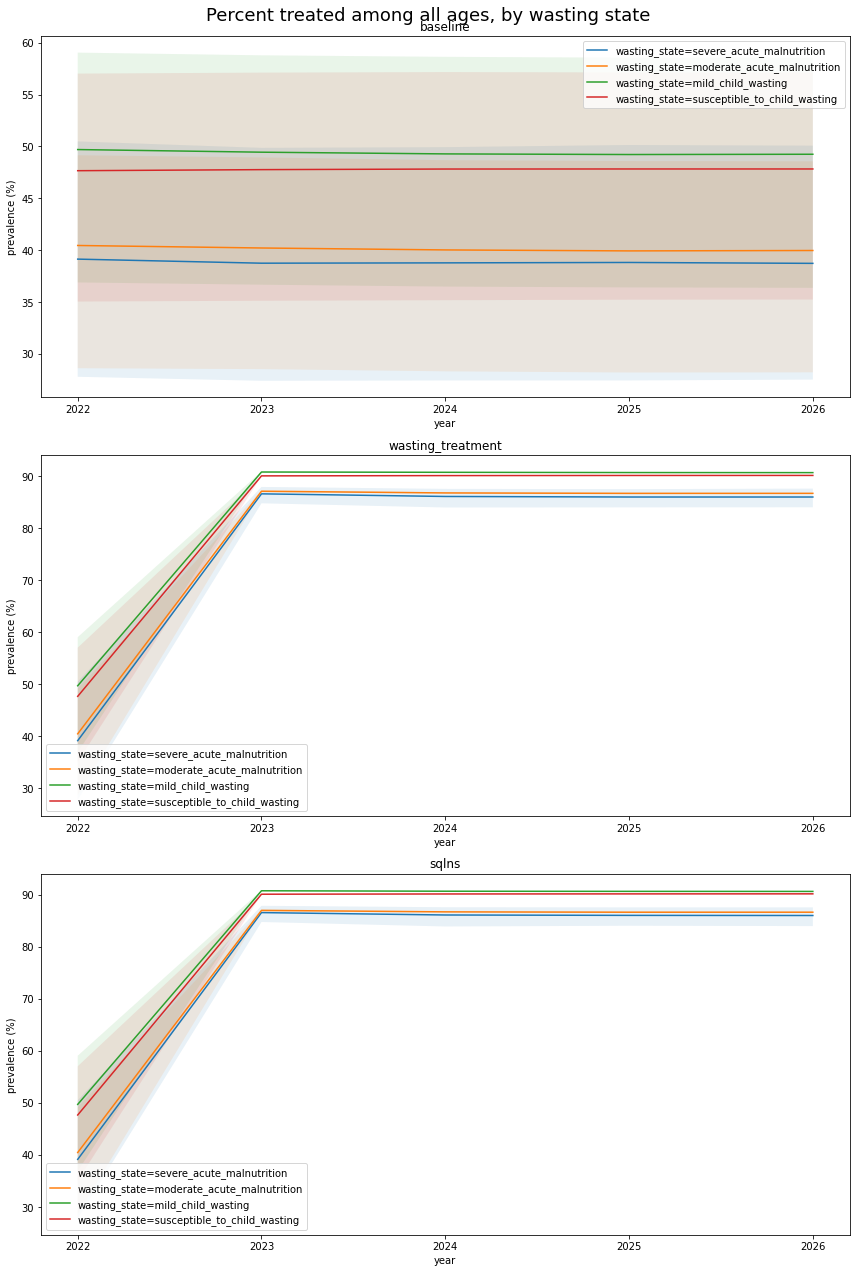

In [14]:
fig = csp.plot_over_time_by_column_for_each_scenario(
    percent_treated_by_year_wasting_state.query("wasting_treatment=='covered'"),
    colname='wasting_state',
    ylabel='prevalence (%)',
    suptitle='Percent treated among all ages, by wasting state',
    uncertainty=True
)

# Compute percent treated by age and wasting state

The patterns seem to make sense:

- Before 6 months, there are no transitions between wasting states, and coverage is constant across states.

- After 6 months, coverage decreases in the SAM and MAM states, and increases in the MILD and TMREL states because covered simulants are actively moved out of SAM and MAM into MILD and TMREL.

In [16]:
percent_treated_by_year_age_wasting_state = csr.get_prevalence(
    results,
    'wasting_treatment',
    strata=['year', 'age', 'wasting_state'],
    multiplier=100
)
percent_treated_by_year_age_wasting_state

,year,age,wasting_state,input_draw,scenario,wasting_treatment,value,numerator_measure,denominator_measure,multiplier,measure
0,2022,1-5_months,mild_child_wasting,29,baseline,covered,49.368219,state_person_time,state_person_time,100,prevalence
1,2022,1-5_months,mild_child_wasting,29,baseline,uncovered,50.631781,state_person_time,state_person_time,100,prevalence
2,2022,1-5_months,mild_child_wasting,29,sqlns,covered,49.368219,state_person_time,state_person_time,100,prevalence
3,2022,1-5_months,mild_child_wasting,29,sqlns,uncovered,50.631781,state_person_time,state_person_time,100,prevalence
...,...,...,...,...,...,...,...,...,...,...,...
8636,2026,late_neonatal,susceptible_to_child_wasting,946,sqlns,covered,90.075614,state_person_time,state_person_time,100,prevalence
8637,2026,late_neonatal,susceptible_to_child_wasting,946,sqlns,uncovered,9.924386,state_person_time,state_person_time,100,prevalence
8638,2026,late_neonatal,susceptible_to_child_wasting,946,wasting_treatment,covered,90.075614,state_person_time,state_person_time,100,prevalence
8639,2026,late_neonatal,susceptible_to_child_wasting,946,wasting_treatment,uncovered,9.924386,state_person_time,state_person_time,100,prevalence


In [18]:
percent_treated_by_year_age_wasting_state.age.unique()

array(['1-5_months', '12_to_23_months', '2_to_4', '6-11_months',
       'early_neonatal', 'late_neonatal'], dtype=object)

In [20]:
csr.get_age_group_bins('all_ages')

(['early_neonatal', 'late_neonatal', '1-5_months', '6-11_months', '12_to_23_months', '2_to_4']
 Categories (7, object): ['early_neonatal' < 'late_neonatal' < '1-5_months' < '6-11_months' < '12_to_23_months' < '2_to_4' < 'all_ages'],
 ['all_ages']
 Categories (7, object): ['early_neonatal' < 'late_neonatal' < '1-5_months' < '6-11_months' < '12_to_23_months' < '2_to_4' < 'all_ages'])

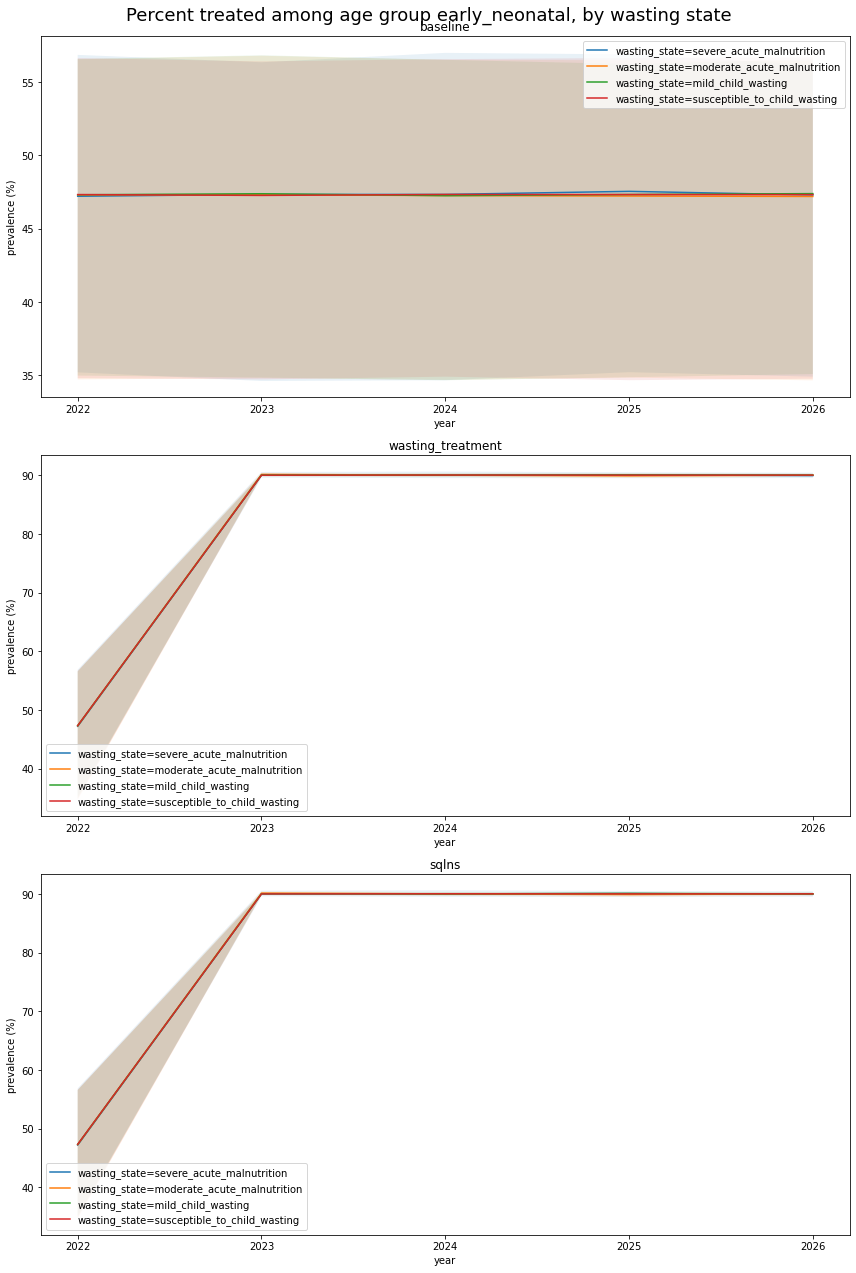

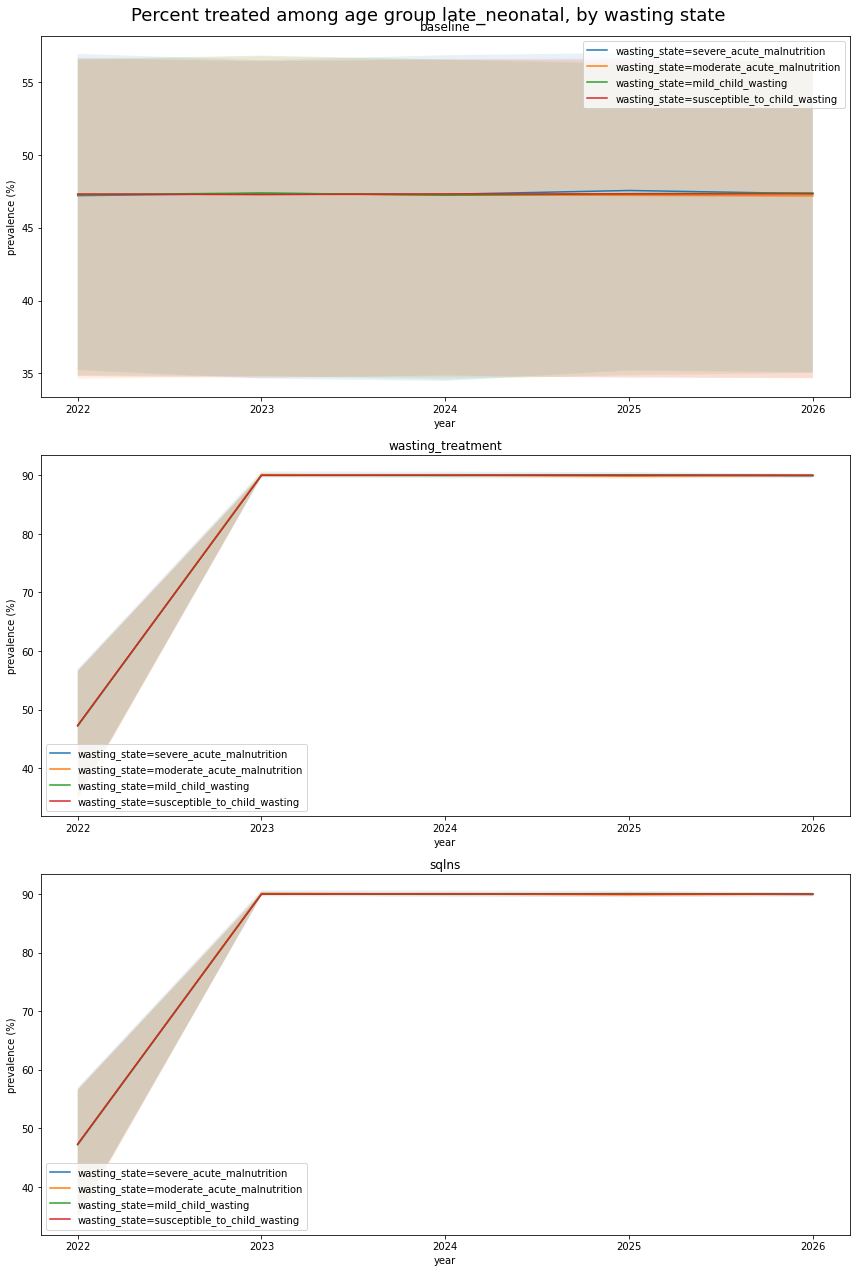

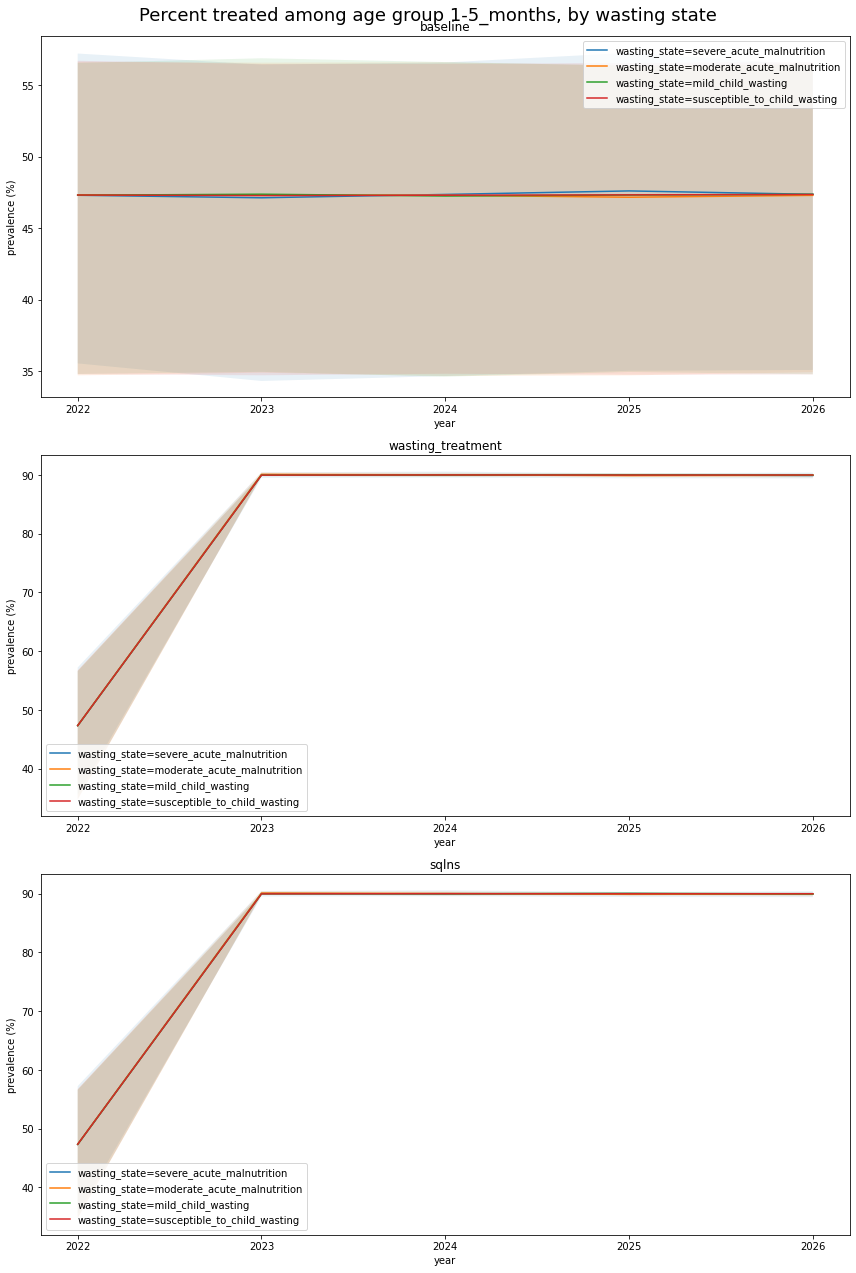

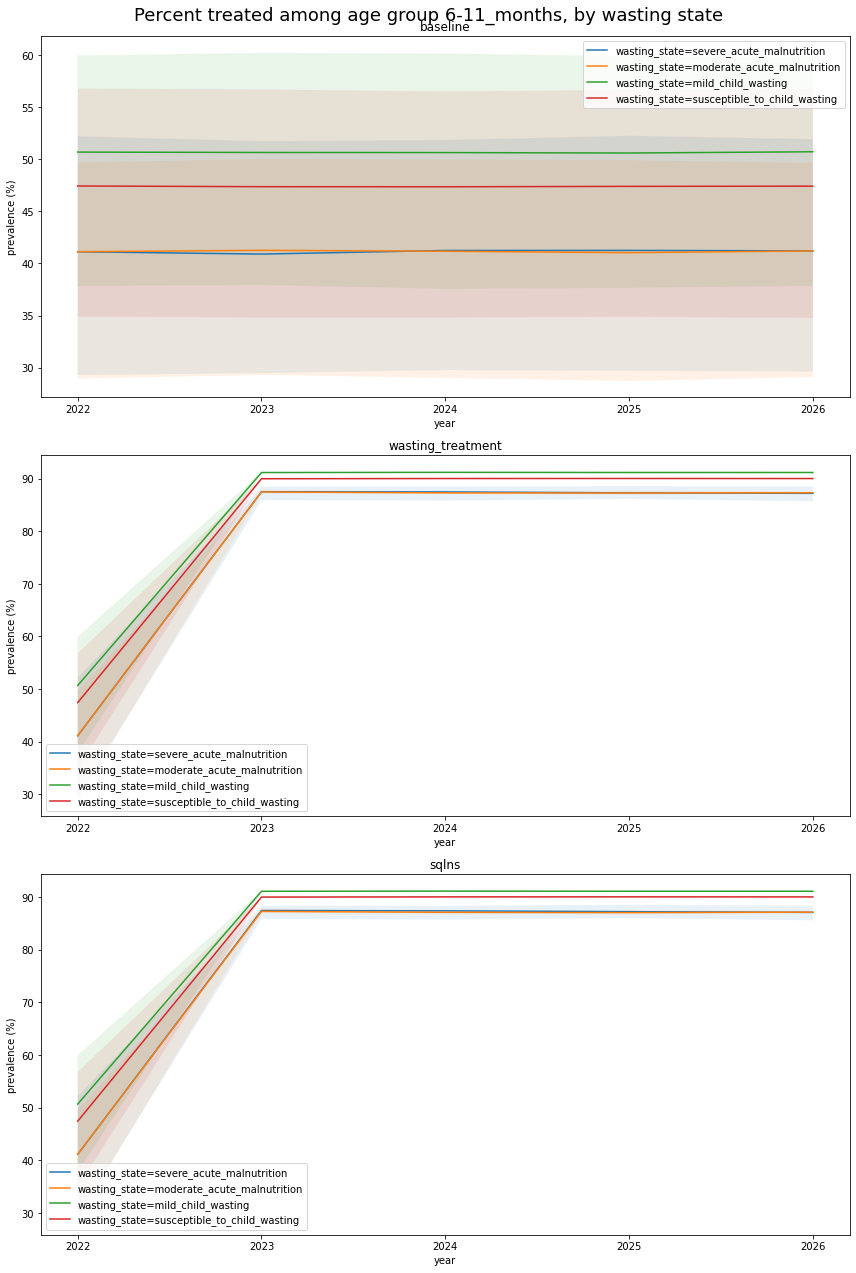

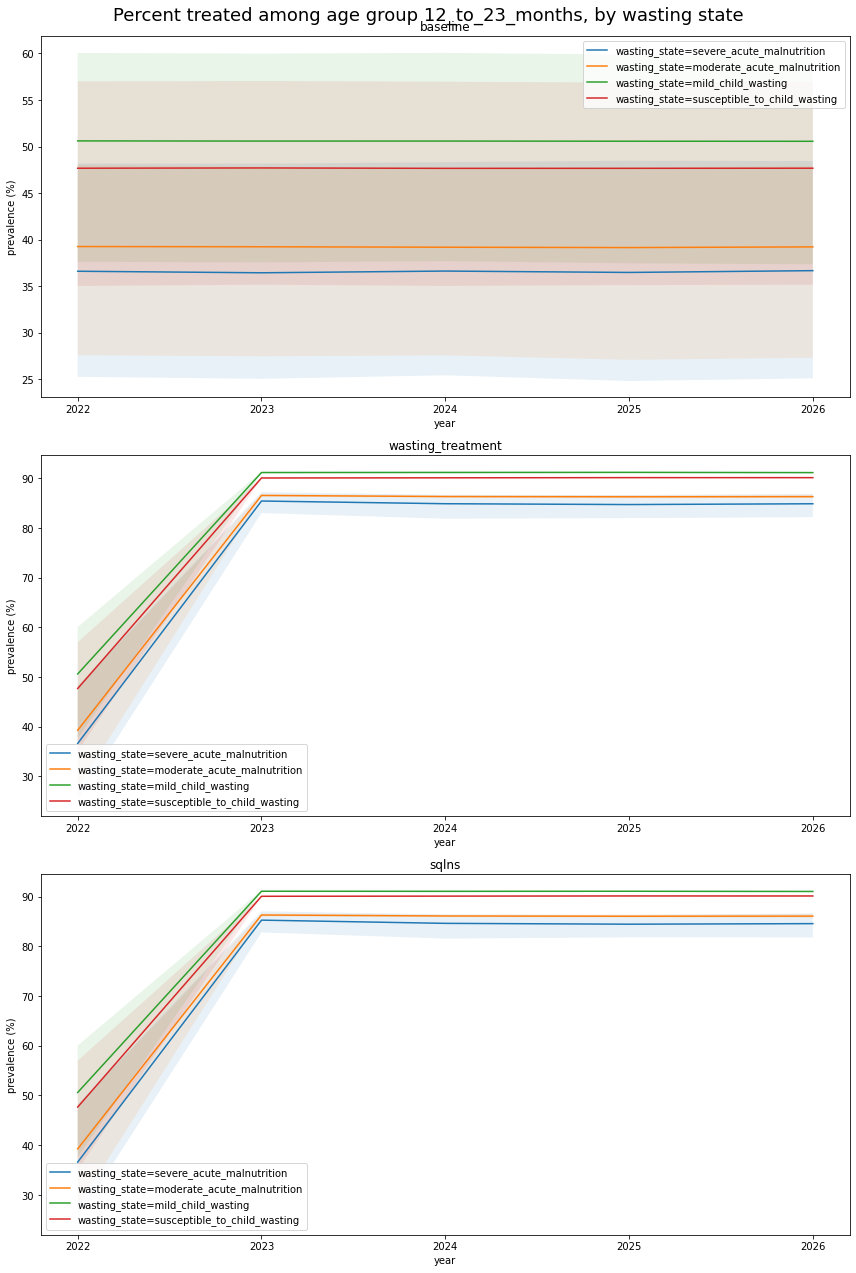

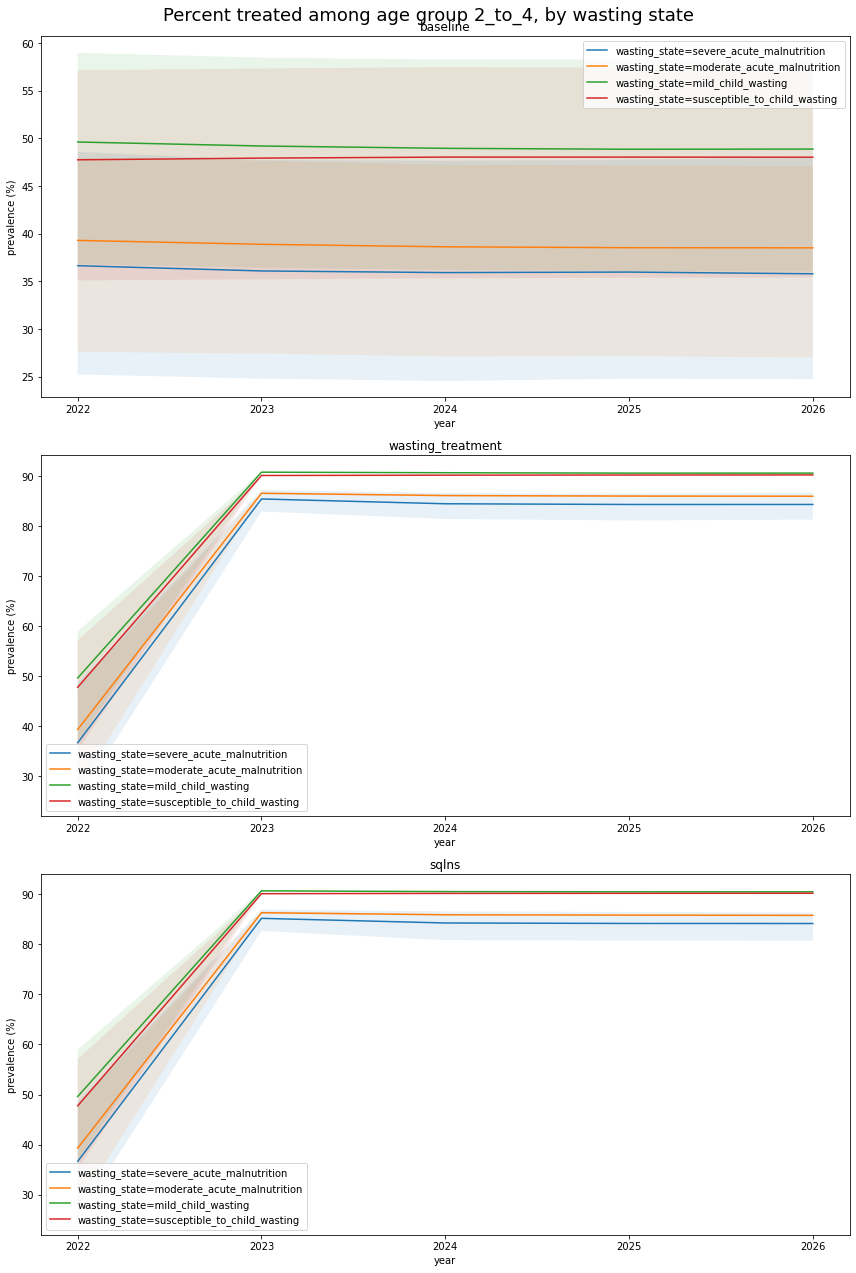

In [22]:
for age in csr.get_age_group_bins('all_ages')[0]:
    title = f'Percent treated among age group {age}, by wasting state'
    fig = csp.plot_over_time_by_column_for_each_scenario(
        percent_treated_by_year_age_wasting_state.query(
            f"wasting_treatment=='covered' and age=={age!r}"),
        colname='wasting_state',
        ylabel='prevalence (%)',
        suptitle=title,
        uncertainty=True
    )
    figs[title]=fig

In [23]:
figs.keys()

dict_keys(['Percent treated among age group early_neonatal, by wasting state', 'Percent treated among age group late_neonatal, by wasting state', 'Percent treated among age group 1-5_months, by wasting state', 'Percent treated among age group 6-11_months, by wasting state', 'Percent treated among age group 12_to_23_months, by wasting state', 'Percent treated among age group 2_to_4, by wasting state'])

# Check coverage values in intervention scenarios

It seems strange that all the values look lower than 90%, but actually MILD and TMREL are slightly above 90%, so it must be that the prevalence of MAM and SAM is very small, and the prevalence-weighted average comes out to 90%. Let's double-check.

In [26]:
vp.describe(
    percent_treated_by_year_age_wasting_state.query(
        "scenario=='wasting_treatment' and wasting_treatment=='covered' and year=='2026' and age=='2_to_4'"
    )
)

count  \
age    denominator_measure measure    multiplier numerator_measure scenario          wasting_state                wasting_treatment year          
2_to_4 state_person_time   prevalence 100        state_person_time wasting_treatment mild_child_wasting           covered           2026   12.0   
                                                                                     moderate_acute_malnutrition  covered           2026   12.0   
                                                                                     severe_acute_malnutrition    covered           2026   12.0   
                                                                                     susceptible_to_child_wasting covered           2026   12.0   

                                                                                                                                               mean  \
age    denominator_measure measure    multiplier numerator_measure scenario          wasting_state                wasting_treatment year              
2_to_4 state_person_time   prevalence 100        state_person_time wasting_treatment mild_child_wasting           covered           2026  90.612123   
                                                                                     moderate_acute_malnutrition  covered           2026  85.985717   
                                                                                     severe_acute_malnutrition    covered           2026  84.336686   
                                                                                     susceptible_to_child_wasting covered           2026  90.248721   

                                                                                                                                               std  \
age    denominator_measure measure    multiplier numerator_measure scenario          wasting_state                wasting_treatment year             
2_to_4 state_person_time   prevalence 100        state_person_time wasting_treatment mild_child_wasting           covered           2026  0.057427   
                                                                                     moderate_acute_malnutrition  covered           2026  0.078637   
                                                                                     severe_acute_malnutrition    covered           2026  1.725048   
                                                                                     susceptible_to_child_wasting covered           2026  0.045988   

                                                                                                                                                min  \
age    denominator_measure measure    multiplier numerator_measure scenario          wasting_state                wasting_treatment year              
2_to_4 state_person_time   prevalence 100        state_person_time wasting_treatment mild_child_wasting           covered           2026  90.532350   
                                                                                     moderate_acute_malnutrition  covered           2026  85.856107   
                                                                                     severe_acute_malnutrition    covered           2026  80.737515   
                                                                                     susceptible_to_child_wasting covered           2026  90.163577   

                                                                                                                                               2.5%  \
age    denominator_measure measure    multiplier numerator_measure scenario          wasting_state                wasting_treatment year              
2_to_4 state_person_time   prevalence 100        state_person_time wasting_treatment mild_child_wasting           covered           2026  90.533063   
                                                                                     mo

In [27]:
vp.describe(
    percent_treated_by_year_age_wasting_state.query(
        "scenario=='sqlns' and wasting_treatment=='covered' and year=='2026' and age=='2_to_4'"
    )
)

count  \
age    denominator_measure measure    multiplier numerator_measure scenario wasting_state                wasting_treatment year          
2_to_4 state_person_time   prevalence 100        state_person_time sqlns    mild_child_wasting           covered           2026   12.0   
                                                                            moderate_acute_malnutrition  covered           2026   12.0   
                                                                            severe_acute_malnutrition    covered           2026   12.0   
                                                                            susceptible_to_child_wasting covered           2026   12.0   

                                                                                                                                      mean  \
age    denominator_measure measure    multiplier numerator_measure scenario wasting_state                wasting_treatment year              
2_to_4 state_person_time   prevalence 100        state_person_time sqlns    mild_child_wasting           covered           2026  90.510716   
                                                                            moderate_acute_malnutrition  covered           2026  85.806176   
                                                                            severe_acute_malnutrition    covered           2026  84.179423   
                                                                            susceptible_to_child_wasting covered           2026  90.227961   

                                                                                                                                      std  \
age    denominator_measure measure    multiplier numerator_measure scenario wasting_state                wasting_treatment year             
2_to_4 state_person_time   prevalence 100        state_person_time sqlns    mild_child_wasting           covered           2026  0.060516   
                                                                            moderate_acute_malnutrition  covered           2026  0.107547   
                                                                            severe_acute_malnutrition    covered           2026  1.813762   
                                                                            susceptible_to_child_wasting covered           2026  0.042730   

                                                                                                                                       min  \
age    denominator_measure measure    multiplier numerator_measure scenario wasting_state                wasting_treatment year              
2_to_4 state_person_time   prevalence 100        state_person_time sqlns    mild_child_wasting           covered           2026  90.422287   
                                                                            moderate_acute_malnutrition  covered           2026  85.605064   
                                                                            severe_acute_malnutrition    covered           2026  80.016987   
                                                                            susceptible_to_child_wasting covered           2026  90.137240   

                                                                                                                                      2.5%  \
age    denominator_measure measure    multiplier numerator_measure scenario wasting_state                wasting_treatment year              
2_to_4 state_person_time   prevalence 100        state_person_time sqlns    mild_child_wasting           covered           2026  90.422431   
                                                                            moderate_acute_malnutrition  covered           2026  85.631495   
                                                                            severe_acute_malnutrition    covered           2026  80.744671   
                                     

## Compute prevalence of wasting states

In [28]:
wasting_state_prevalence_by_year_age = csr.get_prevalence(
    results,
    'wasting_state',
    strata=['year', 'age']
)
wasting_state_prevalence_by_year_age

,year,age,input_draw,scenario,wasting_state,value,numerator_measure,denominator_measure,multiplier,measure
0,2022,1-5_months,29,baseline,mild_child_wasting,0.205336,state_person_time,state_person_time,1,prevalence
1,2022,1-5_months,29,baseline,moderate_acute_malnutrition,0.088382,state_person_time,state_person_time,1,prevalence
2,2022,1-5_months,29,baseline,severe_acute_malnutrition,0.029572,state_person_time,state_person_time,1,prevalence
3,2022,1-5_months,29,baseline,susceptible_to_child_wasting,0.676710,state_person_time,state_person_time,1,prevalence
...,...,...,...,...,...,...,...,...,...,...
4316,2026,late_neonatal,946,wasting_treatment,mild_child_wasting,0.200809,state_person_time,state_person_time,1,prevalence
4317,2026,late_neonatal,946,wasting_treatment,moderate_acute_malnutrition,0.089108,state_person_time,state_person_time,1,prevalence
4318,2026,late_neonatal,946,wasting_treatment,severe_acute_malnutrition,0.032706,state_person_time,state_person_time,1,prevalence
4319,2026,late_neonatal,946,wasting_treatment,susceptible_to_child_wasting,0.677378,state_person_time,state_person_time,1,prevalence


## Compute prevalence-weighted coverage by wasting state, year, and age

In [31]:
weighted_coverage_by_year_age_wasting_state = (
    vp.value(wasting_state_prevalence_by_year_age, include=['year', 'age', 'wasting_state'])
    * vp.value(
        percent_treated_by_year_age_wasting_state,
        include=['year', 'age', 'wasting_state', 'wasting_treatment']
    )
)
weighted_coverage_by_year_age_wasting_state

value
year age           wasting_state                input_draw scenario          wasting_treatment           
2022 1-5_months    mild_child_wasting           29         baseline          covered            10.137060
                                                                             uncovered          10.396514
                                                           sqlns             covered            10.137060
                                                                             uncovered          10.396514
...                                                                                                   ...
2026 late_neonatal susceptible_to_child_wasting 946        sqlns             covered            61.015196
                                                                             uncovered           6.722556
                                                           wasting_treatment covered            61.015196
                                                                             uncovered           6.722556

[8640 rows x 1 columns]

## Re-compute coverage by year and age by marginalizing prevalence-weighted coverage over wasting state

In [37]:
percent_treated_by_age_year2 = vp.marginalize(weighted_coverage_by_year_age_wasting_state, 'wasting_state')
percent_treated_by_age_year2

,age,input_draw,scenario,wasting_treatment,year,value
0,1-5_months,29,baseline,covered,2022,49.502033
1,1-5_months,29,baseline,covered,2023,49.572063
2,1-5_months,29,baseline,covered,2024,49.636728
3,1-5_months,29,baseline,covered,2025,49.587077
...,...,...,...,...,...,...
2156,late_neonatal,946,wasting_treatment,uncovered,2023,9.927143
2157,late_neonatal,946,wasting_treatment,uncovered,2024,9.983689
2158,late_neonatal,946,wasting_treatment,uncovered,2025,10.002482
2159,late_neonatal,946,wasting_treatment,uncovered,2026,10.008151


## Check the values in 'sqlns' scenario for year 2026 -- Good, these look the same as the original values we computed before

In [42]:
vp.describe(
    percent_treated_by_age_year2.query(
        "scenario=='sqlns' and wasting_treatment=='covered' and year=='2026'")
)

,,,,count,mean,std,min,2.5%,50%,97.5%,max
age,scenario,wasting_treatment,year,,,,,,,,
1-5_months,sqlns,covered,2026,12.0,89.996902,0.081406,89.822575,89.854715,90.000097,90.133806,90.160211
12_to_23_months,sqlns,covered,2026,12.0,90.007947,0.060248,89.919542,89.925503,89.995615,90.118232,90.133376
2_to_4,sqlns,covered,2026,12.0,90.001625,0.035309,89.922641,89.934248,90.006670,90.056003,90.065549
6-11_months,sqlns,covered,2026,12.0,90.000555,0.069366,89.890768,89.903457,89.987601,90.117395,90.135015
early_neonatal,sqlns,covered,2026,12.0,90.000959,0.082249,89.891099,89.896385,90.000726,90.139377,90.140786
late_neonatal,sqlns,covered,2026,12.0,90.003714,0.073166,89.887522,89.898437,89.992527,90.139711,90.155567


In [43]:
vp.describe(
    percent_treated_by_age_year.query(
        "scenario=='sqlns' and wasting_treatment=='covered' and year=='2026'")
)

,,,,,,,,count,mean,std,min,2.5%,50%,97.5%,max
age,denominator_measure,measure,multiplier,numerator_measure,scenario,wasting_treatment,year,,,,,,,,
1-5_months,state_person_time,prevalence,100,state_person_time,sqlns,covered,2026,12.0,89.996902,0.081406,89.822575,89.854715,90.000097,90.133806,90.160211
12_to_23_months,state_person_time,prevalence,100,state_person_time,sqlns,covered,2026,12.0,90.007947,0.060248,89.919542,89.925503,89.995615,90.118232,90.133376
2_to_4,state_person_time,prevalence,100,state_person_time,sqlns,covered,2026,12.0,90.001625,0.035309,89.922641,89.934248,90.006670,90.056003,90.065549
6-11_months,state_person_time,prevalence,100,state_person_time,sqlns,covered,2026,12.0,90.000555,0.069366,89.890768,89.903457,89.987601,90.117395,90.135015
early_neonatal,state_person_time,prevalence,100,state_person_time,sqlns,covered,2026,12.0,90.000959,0.082249,89.891099,89.896385,90.000726,90.139377,90.140786
late_neonatal,state_person_time,prevalence,100,state_person_time,sqlns,covered,2026,12.0,90.003714,0.073166,89.887522,89.898437,89.992527,90.139711,90.155567


## Compare all the newly computed coverage values to what we got before -- Good, they are equal

In [39]:
percent_treated_by_age_year

,age,year,input_draw,scenario,wasting_treatment,value,numerator_measure,denominator_measure,multiplier,measure
0,1-5_months,2022,29,baseline,covered,49.502033,state_person_time,state_person_time,100,prevalence
1,1-5_months,2022,29,baseline,uncovered,50.497967,state_person_time,state_person_time,100,prevalence
2,1-5_months,2022,29,sqlns,covered,49.502033,state_person_time,state_person_time,100,prevalence
3,1-5_months,2022,29,sqlns,uncovered,50.497967,state_person_time,state_person_time,100,prevalence
...,...,...,...,...,...,...,...,...,...,...
2156,late_neonatal,2026,946,sqlns,covered,89.991849,state_person_time,state_person_time,100,prevalence
2157,late_neonatal,2026,946,sqlns,uncovered,10.008151,state_person_time,state_person_time,100,prevalence
2158,late_neonatal,2026,946,wasting_treatment,covered,89.991849,state_person_time,state_person_time,100,prevalence
2159,late_neonatal,2026,946,wasting_treatment,uncovered,10.008151,state_person_time,state_person_time,100,prevalence


In [40]:
vp.assert_values_equal(
    percent_treated_by_age_year[percent_treated_by_age_year2.columns],
    percent_treated_by_age_year2,
)